#### 참고 --> https://github.com/YooSungHyun/attention-time-forecast/tree/master

In [1]:
import pandas as pd
import numpy as np
from numpy import array

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
%matplotlib inline

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [3]:
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [5]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [31]:
class Encoderlstm(Layer):
    def __init__(self, m):
        """
        m : feature dimension
        h0 : initial hidden state
        c0 : initial cell state
        """
        super(Encoderlstm, self).__init__(name="encoder_lstm")
        self.lstm = LSTM(m, return_state=True)
        self.initial_state = None

    def call(self, x, training=False):
        """
        x : t 번째 input data (shape = batch,1,n)
        """
        h_s, _, c_s = self.lstm(x, initial_state=self.initial_state)
        self.initial_state = [h_s, c_s]
        return h_s, c_s

    def reset_state(self, h0, c0):
        self.initial_state = [h0, c0]


class InputAttention(Layer):
    def __init__(self, T):
        super(InputAttention, self).__init__(name="input_attention")
        self.w1 = Dense(T)
        self.w2 = Dense(T)
        self.v = Dense(1)

    def call(self, h_s, c_s, x):
        """
        h_s : hidden_state (shape = batch,m)
        c_s : cell_state (shape = batch,m)
        x : time series encoder inputs (shape = batch,T,n)
        """
        # 논문에서 hidden과 cell state를 concat하여 어텐션하는게 정확도가 더 높다고 한다.
        query = tf.concat([h_s, c_s], axis=-1)  # batch, m*2
        # 특징 개수만큼 hidden과 cell 합친 상태를 불린다. (각 특징만큼 hidden과 cell의 어텐션을 보기 위함이니까.)
        query = RepeatVector(tf.shape(x)[2])(query)  # batch, n, m*2
        # 2열과 1열 전치
        x_perm = Permute((2, 1))(x)  # batch, n, T

        # 일반적인 바다나우 어텐션 실시.
        score = tf.nn.tanh(self.w1(x_perm) + self.w2(query))  # batch, n, T

        # 1 시계열에 대한, 특징들의 scoring이 진행된다.
        score = self.v(score)  # batch, n, 1
        
        # Attention Weight가 1 시계열에 대한 특징들의 어텐션이었으니, 소스에서 인지하기 쉽게 2열 1열 다시 전치
        score = Permute((2, 1))(score)  # batch,1,n

        attention_weights = tf.nn.softmax(score)  # t 번째 time step 일 때 각 feature 별 중요도
        return attention_weights


class Encoder(Layer):
    def __init__(self, T, m):
        super(Encoder, self).__init__(name="encoder")
        """
        m : 인코더 LSTM의 Units(outputs) 개수. (lstm의 출력을 몇개의 차원으로 할 것인가?)
        """
        self.T = T
        self.input_att = InputAttention(T)
        self.lstm = Encoderlstm(m)
        self.initial_state = None
        self.alpha_t = None

    def call(self, data, h0, c0, n, training=False):
        """
        data : encoder data (shape = batch, T, n)
        n : data feature num
        """
        # state setting
        self.lstm.reset_state(h0=h0, c0=c0)

        # 시간별 result를 담을 array 생성
        alpha_seq = tf.TensorArray(tf.float32, self.T)
        
        # 이부분은 각자 데이터셋에 따라 수정이 필요할 수 있다.
        # 근데, 사실상 encoder는 집어넣은 dataset의 timestep을 다 쓸테니, 수정이 필요하지 않는게 일반적일듯 하다.
        for t in range(self.T):

            # 배치단위로 각 시간순서의 값들을 떼어서 3차원으로 변환시켜준다
            # 24시간으로 가정하면, 1배치의 모든 0시 값을 t=0에 수행
            x = Lambda(lambda x: data[:, t, :])(data)
            x = x[:, tf.newaxis, :]
            # x : (batch_size,1,n)
            
            # 각 배치의 모든 시 1 time을 넣어서 lstm을 수행한다. (1 time step lstm)
            h_s, c_s = self.lstm(x)
            # h_s, c_s : (batch_size, m)

            # 1 time step에 대한 input attetnion을 진행한다.
            self.alpha_t = self.input_att(h_s, c_s, data)  # batch,1,n
            # 한 시계열에 대한 feature attention score가 출력된다.

            # 이후에 곱을 한꺼번에 진행하기 위해서 value와 곱하는 과정을 먼저 수행하진 않고 결과 array에 전부 넣어놓는다.
            alpha_seq = alpha_seq.write(t, self.alpha_t)

        # 각 시계열별로 특징들에 대한 weight를 전부 계산하고, array를 1개로 합쳐 최종 시계열별 특징 중요도에 대한 array set를 완성한다.
        alpha_seq = tf.reshape(alpha_seq.stack(), (-1, self.T, n))  # batch, T, n

        # Attention Weight * Value를 통해, 실제 Context_Vector set를 구하게 된다.
        # 결과적으로는 각 시간 time-line별로 가장 중요하게 생각되는 특성들만 값이 높아지게 된다.
        output = tf.multiply(data, alpha_seq)  # batch, T, n

        return output


class Decoderlstm(Layer):
    def __init__(self, p):
        """
        p : feature dimension
        h0 : initial hidden state
        c0 : initial cell state
        """
        super(Decoderlstm, self).__init__(name="decoder_lstm")
        self.lstm = LSTM(p, return_state=True)
        self.initial_state = None

    def call(self, x, training=False):
        """
        x : t 번째 input data (shape = batch,1,n)
        """
        h_s, _, c_s = self.lstm(x, initial_state=self.initial_state)
        self.initial_state = [h_s, c_s]
        return h_s, c_s

    def reset_state(self, h0, c0):
        self.initial_state = [h0, c0]


class TemporalAttention(Layer):
    def __init__(self, m):
        super(TemporalAttention, self).__init__(name="temporal_attention")
        self.w1 = Dense(m)
        self.w2 = Dense(m)
        self.v = Dense(1)

    def call(self, h_s, c_s, enc_h):
        """
        h_s : hidden_state (shape = batch,p)
        c_s : cell_state (shape = batch,p)
        enc_h : time series encoder inputs (shape = batch,T,m)
        """
        # 평범한 바다나우 어텐션이 진행된다.
        query = tf.concat([h_s, c_s], axis=-1)  # batch, p*2
        # 여기서는 시계열만큼을 복사한다는데 유의하자. decoder의 temporal attention은 일반적인 바다나우와 같이, 시간에 대한 attention이 계산된다.
        query = RepeatVector(tf.shape(enc_h)[1])(query)
        score = tf.nn.tanh(self.w1(enc_h) + self.w2(query))  # batch, T, m
        score = self.v(score)  # batch, T, 1
        attention_weights = tf.nn.softmax(
            score, axis=1
        )  # encoder hidden state h(i) 의 중요성 (0<=i<=T)
        return attention_weights


class Decoder(Layer):
    def __init__(self, T, p, m):
        super(Decoder, self).__init__(name="decoder")
        self.T = T
        self.temp_att = TemporalAttention(m)
        self.dense = Dense(1)
        self.lstm = Decoderlstm(p)
        self.enc_lstm_dim = m
        self.dec_lstm_dim = p
        self.context_v = None
        self.dec_h_s = None
        self.beta_t = None

    def call(self, data, enc_h, h0=None, c0=None, training=False):
        """
        data : decoder data
        enc_h : encoder hidden state (shape = batch, T, m)
        """

        h_s = None
        self.lstm.reset_state(h0=h0, c0=c0)

        self.context_v = tf.zeros((tf.shape(enc_h)[0], 1, self.enc_lstm_dim))  # batch,1,m
        self.dec_h_s = tf.zeros((tf.shape(enc_h)[0], self.dec_lstm_dim))  # batch, p
        # 이부분은 각자 데이터셋에 따라 수정이 필요할 수 있다.
        # 필자는 이것저것 시도해봤었는데, 이부분은 decoder time step 전체를 보고 어떤 값 1개를 예측하기 위함이었다.
        for t in range(data.shape[1]):
            # decoder에 집어넣은 data를 모든 배치별 1 time step으로 분리한다.
            x = Lambda(lambda x: data[:, t, :])(data)
            x = x[:, tf.newaxis, :]  #  (batch,1,특징값 혹은 예측할값 기타등등?<-구성하기 나름이겠다.)

            # 바다나우 어텐션과 동일하게, x와 context_vector를 concat
            x = tf.concat([x, self.context_v], axis=-1) # batch, 1, m+1
            x = self.dense(x)  # batch,1,특징 갯수 혹은 예측해야할 갯수+context_vector size

            # attention을 진행할 decoder의 hidden과 cell을 구한다.
            h_s, c_s = self.lstm(x)  # batch,p


            # encoding에서 weighted sum된 특징값들을 통해서 (특징 중요도로 학습한 결과로), decoder에서는 시간에 대한 attention이 진행되게 된다.
            self.beta_t = self.temp_att(h_s, c_s, enc_h)  # batch, T, 1
            # 결과는 시간들에 있어서 가장 중요한 값이 뭐였는지에 대한 weigth가 나온다

            # 실제로 encoder 시간값들(사실상 value)에 곱해서 가장 유의미했던 시간값들의 특징값에는 더 많은 가중치가 곱해지게 된다.
            self.context_v = tf.matmul(
                self.beta_t, enc_h, transpose_a=True
            )  # batch,1,m

        return tf.concat(
            [h_s[:, tf.newaxis, :], self.context_v], axis=-1
        )  # batch,1,m+p


class DARNN(Model):
    def __init__(self, T, m, p, target_len):
        super(DARNN, self).__init__(name="DARNN")
        """
        T : time step (24시간이면 24)
        m : encoder lstm feature(output) length (정확히는 encoder lstm의 유닛개수)
        p : decoder lstm feature(output) length (정확히는 decoder lstm의 유닛개수)
        h0 : lstm hidden state
        c0 : lstm cell state
        target_len : 예측할 Y의 개수 (24시간에 대한 기온,풍속,기압 을 예측할거면 target_len=3)
        """
        self.m = m
        self.encoder = Encoder(T=T, m=m)
        self.decoder = Decoder(T=T, p=p, m=m)
        self.lstm = LSTM(m, return_sequences=True)
        self.dense1 = Dense(p)
        self.dense2 = Dense(target_len)

    def call(self, inputs, training=False, mask=None):
        """
        inputs : [enc , dec]
        enc_data : batch,T,n
        dec_data : batch,T-1,1
        """
        
        enc_data, dec_data = inputs
        batch = tf.shape(enc_data)[0]

        '''
        h0, c0는 솔직히 요즘 keras에서 초기화가 꼭 필요한지 궁금하다.
        공식 개발자 가이드를 찾아봐도, 초기 h0과 c0은 0 dimension으로 채워진다고 되어있다.
        '''
        h0 = tf.zeros((batch, self.m))
        c0 = tf.zeros((batch, self.m))
        
        # input attention을 이용하여, 각 시계열별 특징 중요도를 한땀한땀 계산하여 output에 해당하는 dimension으로 출력한다.
        enc_output = self.encoder(
            enc_data, n=tf.shape(enc_data)[2], h0=h0, c0=c0, training=training
        )  # output : (batch_size, T, n)

        # 전부 재계산된 context_vector를 통해서, 전 시계열을 1회 학습한다.
        enc_h = self.lstm(enc_output)  # batch, T, m

        # temporal attention을 이용하여, enc 시계열 대비 dec 시계열이 어떤 시계열에 attention되는지를 계산한다.
        dec_output = self.decoder(
            dec_data, enc_h, h0=h0, c0=c0, training=training
        )  # output : (batch_size,1,m+p)
        
        # 전체 특징단위, 시간단위 유의미한 값들이 가중된 어떤 벡터값이 나오니, 그냥 NN 시킨다.
        output = self.dense2(self.dense1(dec_output))
        output = tf.squeeze(output)
        return output

In [7]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
print(data.columns)
data.head()

(270, 10)
Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [8]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [9]:
train_data.shape,test_data.shape

((210,), (60,))

In [10]:
seasonal = pd.read_csv('계절성예측.csv')

In [11]:
raw_df = data

In [12]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

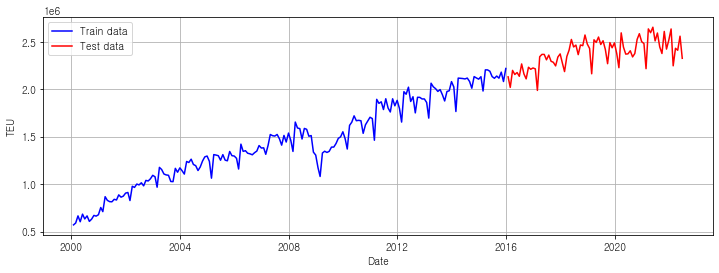

In [13]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [14]:
len(train),len(test)

(192, 78)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지','환율', '화물수송총괄', '수출물가지수']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [16]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [17]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [18]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [19]:
X_train.shape,Y_train.shape

((163, 18, 10), (163, 12, 1))

In [20]:
enc_train = X_train
dec_train = Y_train
y_train = Y_train.reshape(163,12)

In [21]:
enc_train.shape,dec_train.shape,y_train.shape

((163, 18, 10), (163, 12, 1), (163, 12))

### 2. X_test,Y_test 배열

In [22]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_test.shape,Y_test.shape

((49, 18, 10), (49, 12, 1))

In [24]:
enc_test = X_test
dec_test = Y_test
y_test = Y_test.reshape(49,12)

In [25]:
enc_test.shape,dec_test.shape,y_test.shape

((49, 18, 10), (49, 12, 1), (49, 12))

In [32]:
%load_ext autoreload
%autoreload 2

# Input Sequence ( 입력 시차 길이 )
T = 18

# 인코더 셀 개수
m = 64

# 디코더 셀 개수 
p = 64

batch_size = 10 # 훈련 배치 사이즈

# 논문에서 Encoder & Decoder 셀 개수가 서로 일치해야 성능이 가장 좋음(?) / 논문은 (64,64) & (128,128)이 제일 좋음 
model = DARNN(T=T, m=m, p=p, target_len=12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: Attempt to convert a value (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x0000028ACE87C0D0>) with an unsupported type (<class 'tensorflow.python.keras.layers.recurrent_v2.LSTM'>) to a Tensor.

In [26]:
# epoch 돌아가는 쪽 소스를 수정할 거면, 굳이, tf dataset을 사용할 필요는 없다.

train_ds = (
    tf.data.Dataset.from_tensor_slices(
        (enc_train, dec_train, y_train)
    )
    .batch(batch_size)
#     .shuffle(buffer_size=20000)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices(
    (enc_test, dec_test, y_test)
).batch(batch_size)

In [27]:
y_test.shape

(49, 12)

In [28]:
@tf.function
def train_step(model,inputs,labels,loss_fn,optimizer,train_loss):
    with tf.GradientTape() as tape:
        prediction = model(inputs,training=True)
        print(prediction.shape)
        print(labels.shape)
        loss = loss_fn(labels,prediction)
        print(loss)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    train_loss(loss)

loss_fn = tf.keras.losses.MAE

optimizer = tf.keras.optimizers.Adam(0.001)
train_loss = tf.keras.metrics.Mean(name = 'train_loss')

for epoch in range(500):
    for enc,dec,label in train_ds:
        inputs = [enc,dec]
        train_step(model,inputs,label,loss_fn,optimizer,train_loss)

    print(f"epoch : {epoch+1}, train_loss : {train_loss.result()}")
    train_loss.reset_states()

(10, 12)
(10, 12)
Tensor("Mean:0", shape=(10,), dtype=float32)
(10, 12)
(10, 12)
Tensor("Mean:0", shape=(10,), dtype=float32)
(3, 12)
(3, 12)
Tensor("Mean:0", shape=(3,), dtype=float32)
epoch : 1, train_loss : 0.40517786145210266
epoch : 2, train_loss : 0.3434680998325348
epoch : 3, train_loss : 0.10329084098339081
epoch : 4, train_loss : 0.3824543058872223
epoch : 5, train_loss : 0.14462320506572723
epoch : 6, train_loss : 0.24467672407627106
epoch : 7, train_loss : 0.13920022547245026
epoch : 8, train_loss : 0.13705679774284363
epoch : 9, train_loss : 0.08165810257196426
epoch : 10, train_loss : 0.08888217806816101
epoch : 11, train_loss : 0.15262891352176666
epoch : 12, train_loss : 0.08358746021986008
epoch : 13, train_loss : 0.06310922652482986
epoch : 14, train_loss : 0.08599255234003067
epoch : 15, train_loss : 0.1469360888004303
epoch : 16, train_loss : 0.06918172538280487
epoch : 17, train_loss : 0.1308416873216629
epoch : 18, train_loss : 0.12155912816524506
epoch : 19, train

epoch : 178, train_loss : 0.04118218645453453
epoch : 179, train_loss : 0.044905997812747955
epoch : 180, train_loss : 0.052269112318754196
epoch : 181, train_loss : 0.04314166679978371
epoch : 182, train_loss : 0.04654284194111824
epoch : 183, train_loss : 0.052609022706747055
epoch : 184, train_loss : 0.046894293278455734
epoch : 185, train_loss : 0.048730239272117615
epoch : 186, train_loss : 0.04750081151723862
epoch : 187, train_loss : 0.054939497262239456
epoch : 188, train_loss : 0.04971116781234741
epoch : 189, train_loss : 0.04252946749329567
epoch : 190, train_loss : 0.054948583245277405
epoch : 191, train_loss : 0.05681847035884857
epoch : 192, train_loss : 0.04479273408651352
epoch : 193, train_loss : 0.04841054603457451
epoch : 194, train_loss : 0.048647232353687286
epoch : 195, train_loss : 0.05248472839593887
epoch : 196, train_loss : 0.04936349391937256
epoch : 197, train_loss : 0.042544443160295486
epoch : 198, train_loss : 0.05440843105316162
epoch : 199, train_loss :

epoch : 356, train_loss : 0.04209063947200775
epoch : 357, train_loss : 0.0342630110681057
epoch : 358, train_loss : 0.045077256858348846
epoch : 359, train_loss : 0.04731973260641098
epoch : 360, train_loss : 0.038904618471860886
epoch : 361, train_loss : 0.043232958763837814
epoch : 362, train_loss : 0.041231825947761536
epoch : 363, train_loss : 0.04845171421766281
epoch : 364, train_loss : 0.03849567472934723
epoch : 365, train_loss : 0.03287132829427719
epoch : 366, train_loss : 0.03533604368567467
epoch : 367, train_loss : 0.04137888550758362
epoch : 368, train_loss : 0.03756877779960632
epoch : 369, train_loss : 0.03806619346141815
epoch : 370, train_loss : 0.03971337899565697
epoch : 371, train_loss : 0.04177039489150047
epoch : 372, train_loss : 0.03530311584472656
epoch : 373, train_loss : 0.03225742653012276
epoch : 374, train_loss : 0.03412259742617607
epoch : 375, train_loss : 0.03415684774518013
epoch : 376, train_loss : 0.032727643847465515
epoch : 377, train_loss : 0.03

In [29]:
test_loss = tf.keras.metrics.Mean(name = 'test_loss')

@tf.function
def test_step(model,inputs,labels,loss_fn,test_loss):
    prediction = model(inputs,training=True)
    loss = loss_fn(labels,prediction)
    test_loss(loss)
    return prediction

i=0
for enc,dec,label in test_ds:
    inputs = [enc,dec]
    pred = test_step(model,inputs,label,loss_fn,test_loss)
    if i==0:
        preds = pred.numpy()
        labels = label.numpy()
        i+=1
    else:
        preds = np.concatenate([preds, pred.numpy()],axis=0)
        labels = np.concatenate([labels,label.numpy()],axis=0)

print(test_loss.result())

tf.Tensor(0.109378144, shape=(), dtype=float32)


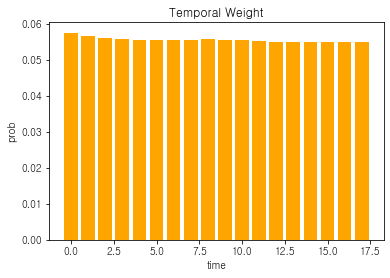

In [30]:
# Beta는 temporal attention에서 나온 시간에 대한 attention weight를 시각화할 수 있다.

enc,dec,label = next(iter(test_ds))
inputs = [enc, dec]
pred = model(inputs)

beta = []

# for문은 time step 만큼 돌린다.
for i in range(18):
    beta.append(np.mean(model.decoder.beta_t[:,i,0].numpy()))  # batch, T, 1

plt.bar(x = range(18), height=beta, color = 'orange')
plt.title("Temporal Weight")
plt.xlabel("time")
plt.ylabel("prob")
plt.show()

In [31]:
beta

[0.05755325,
 0.056713562,
 0.056107085,
 0.0557131,
 0.05550002,
 0.05549825,
 0.05554024,
 0.055633627,
 0.055675108,
 0.055553667,
 0.055409063,
 0.055306416,
 0.055095423,
 0.05503292,
 0.05500269,
 0.054942958,
 0.054868393,
 0.054854207]

In [32]:
preds.shape,labels.shape

((49, 12), (49, 12))

In [33]:
variable_dict = {
    "TEU": [""],
    "BDI": [""],
    "ln(HRCI)": [""],
    "ln(SCFI)": [""],
    "ln(다우존스지수)": [""],
    "전산업생산지수": [""],
    "경상수지": [""],
    "환율": ["13"],
    "화물수송총괄": [""],
    "수출물가지수": [""]
}

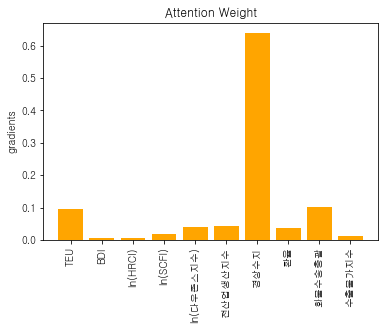

In [34]:
# alpha는 Input Attention에서 나온 특징들에 대한 attention weight를 시각화 할 수 있다.

# variable_key는 특징값들이 들어가있으면된다.
variable_key = list(variable_dict.keys())
alpha = []
variables = []

# for문은 feature len만큼 돌린다.
for i in range(10):
    alpha.append(np.mean(model.encoder.alpha_t[:,0,i].numpy()))
    for key in variable_key:
        # 같은 의미의 값이 여러개 있는경우 숫자를 붙혀줄 수 있는데, 특징이 유니크하게 1개인경우 해당 소스는 필요없다.
        if f"{i}" in variable_dict[key]:
            variables.append(f"{key}{i}")
            
attention_weight = np.array(alpha)
plt.figure(figsize=(6,4))
plt.bar(range(len(attention_weight)), attention_weight,color='orange')
plt.xticks(range(10), variable_key, rotation=90)
plt.ylabel('gradients')
plt.title('Attention Weight')
plt.show()

In [35]:
alpha

[0.094709575,
 0.0077385427,
 0.004940099,
 0.019129178,
 0.040486205,
 0.04282296,
 0.6387185,
 0.037049007,
 0.1010301,
 0.013375828]

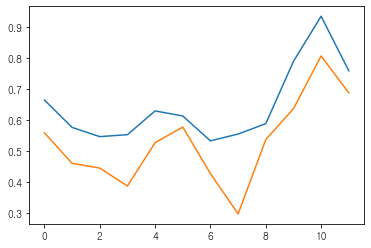

In [36]:
plt.plot(np.array(preds)[0])
plt.plot(np.array(labels)[0])

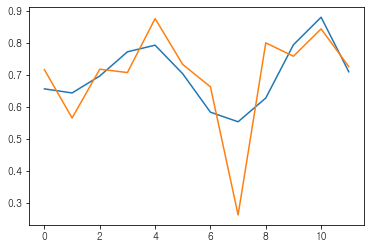

In [37]:
plt.plot(np.array(preds)[12])
plt.plot(np.array(labels)[12])

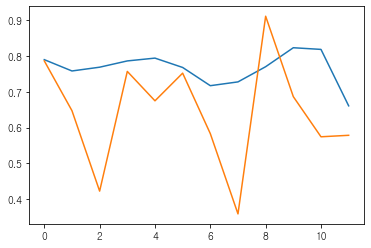

In [38]:
plt.plot(np.array(preds)[24])
plt.plot(np.array(labels)[24])

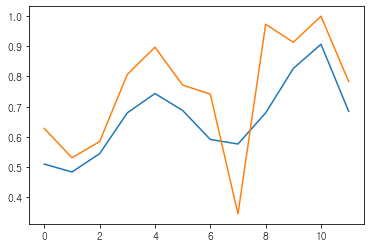

In [39]:
plt.plot(np.array(preds)[36])
plt.plot(np.array(labels)[36])

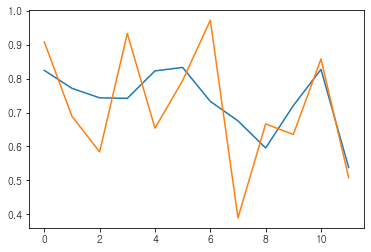

In [40]:
plt.plot(np.array(preds)[48])
plt.plot(np.array(labels)[48])

RMSE: 85537.44804753282
MAPE: 3.332499606856785


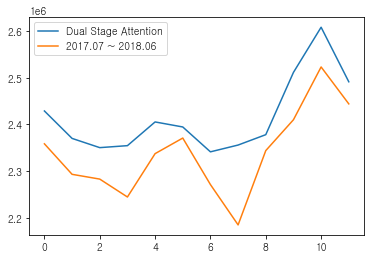

In [41]:
fit = np.array(preds)[0].reshape(-1,1)
fit_repeat = np.repeat(fit,10, axis=-1)
model_fit = scaler.inverse_transform(fit_repeat)
model_fit = np.squeeze(model_fit)[:,0]
df1 = pd.DataFrame(model_fit)

plt.plot(df1[0],label='Dual Stage Attention')
plt.plot(test_data.head(12).reset_index()['TEU'],label='2017.07 ~ 2018.06')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df1[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df1[0])/ test_data.head(12).reset_index()['TEU'])*100) )

RMSE: 73354.8079910311
MAPE: 2.2600291482073156


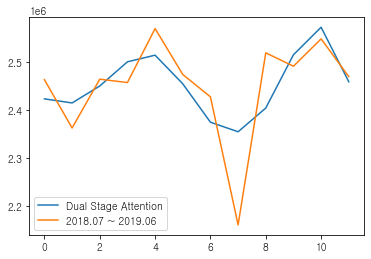

In [42]:
fit = np.array(preds)[12].reshape(-1,1)
fit_repeat = np.repeat(fit,10, axis=-1)
model_fit = scaler.inverse_transform(fit_repeat)
model_fit = np.squeeze(model_fit)[:,0]
df2 = pd.DataFrame(model_fit)

plt.plot(df2[0],label='Dual Stage Attention')
plt.plot(test_data[12:24].reset_index()['TEU'],label='2018.07 ~ 2019.06')
plt.legend(loc=3)

rmse = math.sqrt(mean_squared_error(test_data[12:24].reset_index()['TEU'], df2[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[12:24].reset_index()['TEU']- df2[0])/ test_data[12:24].reset_index()['TEU'])*100) )

RMSE: 122247.42425545721
MAPE: 4.081459812893699


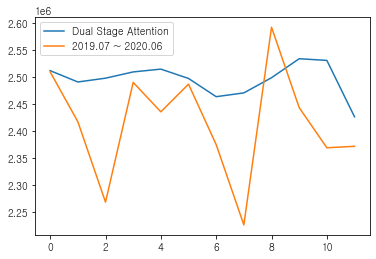

In [43]:
fit = np.array(preds)[24].reshape(-1,1)
fit_repeat = np.repeat(fit,10, axis=-1)
model_fit = scaler.inverse_transform(fit_repeat)
model_fit = np.squeeze(model_fit)[:,0]
df3 = pd.DataFrame(model_fit)

plt.plot(df3[0],label='Dual Stage Attention')
plt.plot(test_data[24:36].reset_index()['TEU'],label='2019.07 ~ 2020.06')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[24:36].reset_index()['TEU'], df3[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[24:36].reset_index()['TEU']- df3[0])/ test_data[24:36].reset_index()['TEU'])*100) )

RMSE: 96832.18518487066
MAPE: 3.4128896546503924


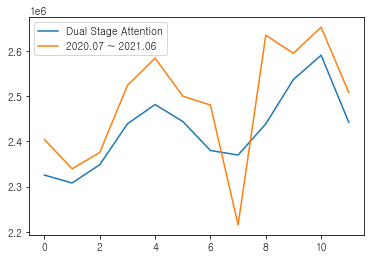

In [44]:
fit = np.array(preds)[36].reshape(-1,1)
fit_repeat = np.repeat(fit,10, axis=-1)
model_fit = scaler.inverse_transform(fit_repeat)
model_fit = np.squeeze(model_fit)[:,0]
df4 = pd.DataFrame(model_fit)

plt.plot(df4[0],label='Dual Stage Attention')
plt.plot(test_data[36:48].reset_index()['TEU'],label='2020.07 ~ 2021.06')
plt.legend(loc=2)

rmse = math.sqrt(mean_squared_error(test_data[36:48].reset_index()['TEU'], df4[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[36:48].reset_index()['TEU']- df4[0])/ test_data[36:48].reset_index()['TEU'])*100) )

RMSE: 97820.30129743966
MAPE: 3.3253070499593


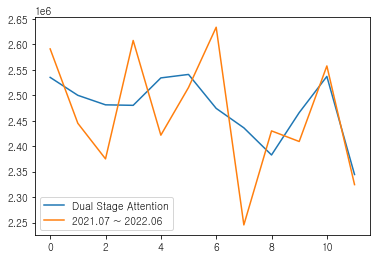

In [45]:
fit = np.array(preds)[48].reshape(-1,1)
fit_repeat = np.repeat(fit,10, axis=-1)
model_fit = scaler.inverse_transform(fit_repeat)
model_fit = np.squeeze(model_fit)[:,0]
df5 = pd.DataFrame(model_fit)

plt.plot(df5[0],label='Dual Stage Attention')
plt.plot(test_data[48:60].reset_index()['TEU'],label='2021.07 ~ 2022.06')
plt.legend(loc=3)

rmse = math.sqrt(mean_squared_error(test_data[48:60].reset_index()['TEU'], df5[0]))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data[48:60].reset_index()['TEU']- df5[0])/ test_data[48:60].reset_index()['TEU'])*100) )

In [46]:
#pd.concat([df1,df2,df3,df4,df5],axis=0).to_csv('DALSTM.csv')